In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams['figure.figsize'] = [8,6]
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import scipy.sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import hstack, vstack

import time
import pylab as pl
from IPython import display

from CoolProp.CoolProp import PropsSI

# Heat exchanger model 


Energy equation: 
$$c_p m \frac{dT}{dx} - A \frac{d}{dx}\left(k\frac{dT}{dx}\right) = Ah \Delta T$$

In discretized form: 
$$-\left(\frac{A k_m}{\Delta x^2}-\frac{c_p m}{2\Delta x}\right)T_{i-1} + \left(\frac{A(k_m+k_p)}{\Delta x^2}\right)T_{i} + \left(-\frac{A k_p}{\Delta x^2}+\frac{c_p m}{2\Delta x}\right)T_{i+1}= Ah \left(T_{ref}-T_i\right)$$ 

### Build linear system of equations for the energy equation

The energy equation in discretized form is

$$c_\text{ld}T_{i-1} + (c_d + Ah) T_{i} + c_{ud}T_{i+1} = Ah T_{ref},$$

where $c_{ld}$ is the coefficient at the 'lower diagonal', $c_d$ at 'diagonal' and $c_{ud}$ at the 'upper diagonal of the linear matrix system. 

The linear system is then

$$
\begin{bmatrix}
d & ud & 0 & \dots & 0\\
ld & d & ud & \ddots  & \vdots \\
0 & ld & d & \ddots  & \vdots \\
\vdots & \ddots  & \ddots  & \ddots & \vdots \\
0 & \dots & \dots & ld & d   \\
\end{bmatrix} 
\begin{bmatrix}T_1 \\ \vdots\\ T_{N-2} \end{bmatrix}
= 
\begin{bmatrix}
-ld \cdot T_{0} \\
\vdots\\
-ud \cdot T_{N-1} 
\end{bmatrix} .
$$

In [53]:
def buildLinSys(T, U, fluid, dx, advecScheme):
    
    npts = np.size(T)
        
    # these should be functions of temperature
    cp = PropsSI('C', "T", T, "P", fluid['pressure'], fluid['fluid'])
    k  = 1.0*np.ones(npts) #PropsSI('L', "T", T, "P", pressure, fluid)
    
    # calculate average k at the faces 
    # 0 ... kave[0] ... 1 ... kave[1] ... 2 ... kave[2] ....... 
    k_average = 0.5*(k[0:-1] + k[1:])
    
    mf = fluid['mass flow']
    if advecScheme == "central":
        mfPl = mf/(2*dx)
        mfMi = mf/(2*dx)
    if advecScheme == "upwind":
        mfPl = (mf+abs(mf))/(2*dx)
        mfMi = (mf-abs(mf))/(2*dx)

    ud = - k_average[1:  ]                  * A/dx**2 + cp[1:-1]* mfMi 
    d  =  (k_average[1:  ]+k_average[0:-1]) * A/dx**2 + cp[1:-1]*(mfPl-mfMi) + U[1:-1]*Per
    ld = - k_average[0:-1]                  * A/dx**2 - cp[1:-1]* mfPl      
    
    rhs = np.zeros(npts-2)

    # add BC's 
    if mf > 0.0: # Dirichlet at the inlet (left), extrapolate at the outlet (right)
        d[-1]   =  d[-1] + 2*ud[-1]
        ld[-1]  = ld[-1] -   ud[-1]
        rhs[ 0] = (A*k_average[0]/dx**2  + mfPl*cp[1]) * T[0]
    else:        # Dirichlet at the inlet (right), extrapolate at the outlet (left)
        d[0]    = ( d[0] + 2*ld[0])
        ud[0]   = (ud[0] -   ld[0])
        rhs[-1] = (A*k_average[-1]/dx**2 - mfMi*cp[-2]) * T[-1]
                  
    # assemble main A matrix 
    ud   = scipy.sparse.diags(    ud,  1, shape=(npts-2,npts-2))
    d    = scipy.sparse.diags(     d,  0, shape=(npts-2,npts-2))
    ld   = scipy.sparse.diags(ld[1:], -1, shape=(npts-2,npts-2))
    Amat = ud + d + ld
    
    return Amat,rhs

### Coupled solver

Both energy equations can also be solved in a coupled manner. Then 

$$ \mathbf A_c \cdot T_c - A~h~T_h = rhs_c $$
$$ \mathbf A_h \cdot T_h - A~h~T_c = rhs_h ,$$

which in matrix form looks like

$$ \begin{bmatrix} 
 [\mathbf A_c] & 
                     \begin{bmatrix}
                     A~h &  & \\
                      & \ddots & \\
                     &  & A~h \\
                     \end{bmatrix} 
 \\
                     \begin{bmatrix}
                     A~h &  & \\
                      & \ddots & \\
                     &  & A~h \\
                 \end{bmatrix} & [A_h]&\\
\end{bmatrix} 
\begin{bmatrix} 
T_c \\ \vdots \\ T_c \\ T_h \\ \vdots \\ T_h \\ 
\end{bmatrix} = rhs ,
$$

Note, $rhs$ only contains the BC's for the temperatures $T_c$ and $T_h$. 

The equations are solved with an under-relaxation parameter $\omega$. Then the linear system is

$$ \left(\mathbf A -\frac{1-\omega}{\omega}\mathbf A_{ii}\right)\cdot T^{k+1} = rhs - \frac{1-\omega}{\omega}\mathbf A_{ii} \cdot T^{k}$$


In [116]:
def solveHEX(colFluid, hotFluid, length, npts=None,
             underrelax=0.8, advecScheme='central', tol=1.0e-3, printResiduals=False):

    if npts is None:
        npts = min(max(int(length/0.04),30), 400) # calculate npts based on dx=0.04

    Tc = np.ones(npts)*colFluid['inlet temp']
    Th = np.ones(npts)*hotFluid['inlet temp']
    
    U  = valueU*np.ones(npts)
    
    x  = np.linspace(0.0, length, npts)
    dx = x[1] - x[0]
    
    iterations = 0
    residual   = 1.0e10

    while iterations < 1000 and residual > tol:

        AmatTc, rhsTc = buildLinSys(Tc, U, colFluid, dx, advecScheme)
        AmatTh, rhsTh = buildLinSys(Th, U, hotFluid, dx, advecScheme)
        
        diagTc = scipy.sparse.diags(-U[1:-1]*Per, 0, shape=(npts-2,npts-2))
        diagTh = scipy.sparse.diags(-U[1:-1]*Per, 0, shape=(npts-2,npts-2))
        Amat = vstack( [hstack([AmatTc,diagTc]), hstack([diagTh,AmatTh])], 'csr')
        
        rhs  = np.concatenate((rhsTc,rhsTh),axis=0)
        temp = np.concatenate((Tc[1:-1],Th[1:-1]),axis=0)

        rhs = rhs + (1-underrelax)/underrelax*Amat.diagonal()*temp
        Amat.setdiag(Amat.diagonal()/underrelax)
        
        temp_old = temp.copy()
        temp     = spsolve(Amat, rhs)
        
        residual = np.linalg.norm(temp-temp_old)/npts
        
        Tc[1:-1] = temp[:npts-2]
        Th[1:-1] = temp[npts-2:]
        
        # fix BC's
        if colFluid['mass flow'] > 0.0:  Tc[-1] = 2*Tc[-2] - Tc[-3]
        else:                            Tc[ 0] = 2*Tc[ 1] - Tc[ 2]

        if hotFluid['mass flow'] > 0.0:  Th[-1] = 2*Th[-2] - Th[-3]
        else:                            Th[ 0] = 2*Th[ 1] - Th[ 2]

        if iterations%100 == 0 and printResiduals == True: 
            print("iterations: ",iterations, ", residual = ", residual)

        iterations += 1

#         plt.plot(Th,'ro')
#         plt.plot(Tc,'bo')

#         display.clear_output(wait=True)
#         display.display(pl.gcf())
#         time.sleep(0.001)
#         plt.clf()
          
    if printResiduals == True:
        print("iterations: ",iterations, ", residual = ", residual,"\n")

    return x, Tc, Th

# Example: check mesh dependency, etc.

iterations:  0 , residual =  3.6781038088953837
iterations:  56 , residual =  0.009294646710058103 

iterations:  0 , residual =  3.6781038088953837
iterations:  100 , residual =  2.1549466867869915e-05
iterations:  124 , residual =  9.289685178889193e-07 

iterations:  0 , residual =  2.0138877226063725
iterations:  100 , residual =  0.0014761472182037603
iterations:  197 , residual =  9.62656868474849e-07 

iterations:  0 , residual =  0.8905437518131736
iterations:  100 , residual =  0.008628900943836637
iterations:  200 , residual =  0.0028589581040733337
iterations:  300 , residual =  0.0006693281150035443
iterations:  400 , residual =  0.00014065695112059726
iterations:  500 , residual =  2.878060075342577e-05
iterations:  600 , residual =  5.848013248584404e-06
iterations:  700 , residual =  1.1865629915510797e-06
iterations:  712 , residual =  9.955905620791473e-07 



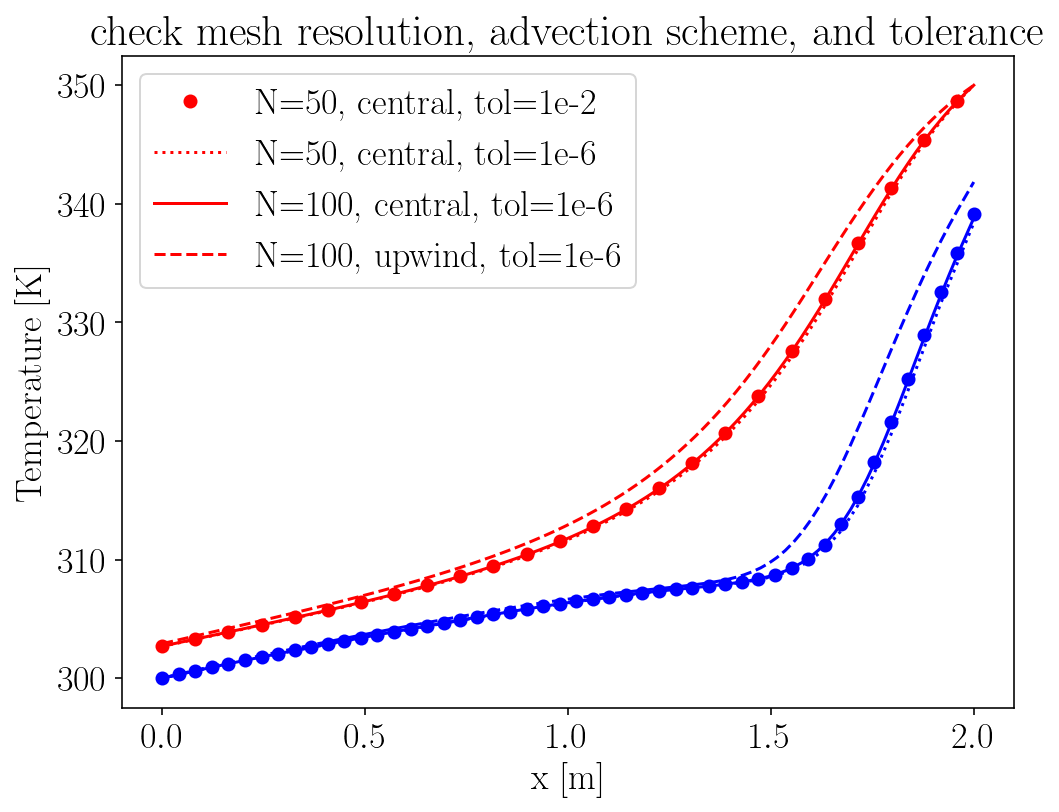

In [117]:
valueU = 2860.0
Per    = 0.4
A      = 1.0

colFluid = {'fluid'     : 'CO2', 
             'pressure'  : 80e5, 
             'inlet temp': 300,
             'mass flow' : 0.1}

hotFluid = {'fluid'     : 'Water', 
            'pressure'  : 1.0e5, 
            'inlet temp': 350, 
            'mass flow' : -0.1}

length = 2

# first case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, 50,
                     underrelax=0.8, tol=1.0e-2, printResiduals=True)
l1, = plt.plot(x[::2],Th[::2],'ro')
plt.plot(x,Tc,'bo')


# second case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, 50,
                     underrelax=0.8, tol=1.0e-6, printResiduals=True)
l2, = plt.plot(x,Th,'r:')
plt.plot(x,Tc,'b:')


# third case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, 100,
                     underrelax=0.8, tol=1.0e-6, printResiduals=True)
l3, = plt.plot(x,Th,'r-')
plt.plot(x,Tc,'b-')


# fourth case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, 100,
                     underrelax=0.8, tol=1.0e-6, printResiduals=True, advecScheme="upwind")
l4, = plt.plot(x,Th,'r--')
plt.plot(x,Tc,'b--')


plt.legend([l1,l2,l3,l4],['N=50,  central, tol=1e-2', 
                          'N=50,  central, tol=1e-6', 
                          'N=100, central, tol=1e-6', 
                          'N=100, upwind,  tol=1e-6'])
plt.title('check mesh resolution, advection scheme, and tolerance')
plt.xlabel("x [m]")
plt.ylabel("Temperature [K]");

### Calculate exergetic efficiency (NOT SURE IF THIS IS CORRECT!!!)

Exergy balance equation:
$$\Delta e = \int_0^L (h - T_0 s)dx$$

Epsilon: 
$$ \varepsilon = \frac{\dot m_c \Delta e_c}{\dot m_h \Delta e_h}$$

In [118]:
import scipy.integrate as integrate

def exerEfficiency(x, colFl, hotFl, Tc, Th, T0):

    # get enthalpy
    h_c = PropsSI('H', "T", Tc, "P", colFl['pressure'], colFl['fluid'])
    h_h = PropsSI('H', "T", Th, "P", hotFl['pressure'], hotFl['fluid'])

    # get entropy
    s_c = PropsSI('S', "T", Tc, "P", colFl['pressure'], colFl['fluid'])
    s_h = PropsSI('S', "T", Th, "P", hotFl['pressure'], hotFl['fluid'])

    DeltaE_c = integrate.simps((h_c-h_c[0]) - T0*(s_c-s_c[0]),x)
    DeltaE_h = integrate.simps((h_h-h_h[0]) - T0*(s_h-s_h[0]),x)

    DeltaE_c *= colFl['mass flow']
    DeltaE_h *= hotFl['mass flow']
    
    return abs(DeltaE_c/DeltaE_h)*100

eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
print('exergetic efficiency, eps = ', eps)

exergetic efficiency, eps =  77.90647859540188


## Example: water-cooled supercritical CO2 power cycle, determine length
Determine length to obtain desired outlet temperature of CO2

Length = 7.645501, CO2 out = 283.000000, deltaTsq = 143.999997
Length = 12.364499, CO2 out = 283.000000, deltaTsq = 144.000000
Length = 4.728999, CO2 out = 283.000871, deltaTsq = 143.979088
Length = 2.926502, CO2 out = 283.247411, deltaTsq = 138.123347
Length = 1.812497, CO2 out = 287.565137, deltaTsq = 55.277191
Length = 1.124005, CO2 out = 297.666103, deltaTsq = 7.108107
Length = 0.698493, CO2 out = 305.696390, deltaTsq = 114.412761
Length = 1.347280, CO2 out = 293.619157, deltaTsq = 1.906729
Length = 1.293747, CO2 out = 294.529305, deltaTsq = 0.221554
Length = 1.271738, CO2 out = 294.951558, deltaTsq = 0.002347
Length = 1.265261, CO2 out = 295.065614, deltaTsq = 0.004305
Length = 1.268919, CO2 out = 295.001142, deltaTsq = 0.000001
Length = 1.268987, CO2 out = 294.999947, deltaTsq = 0.000000
Length = 1.268984, CO2 out = 295.000006, deltaTsq = 0.000000
Length = 1.268980, CO2 out = 295.000065, deltaTsq = 0.000000
length =  1.2689837531095343 

exergetic efficiency, eps =  37.0002242690

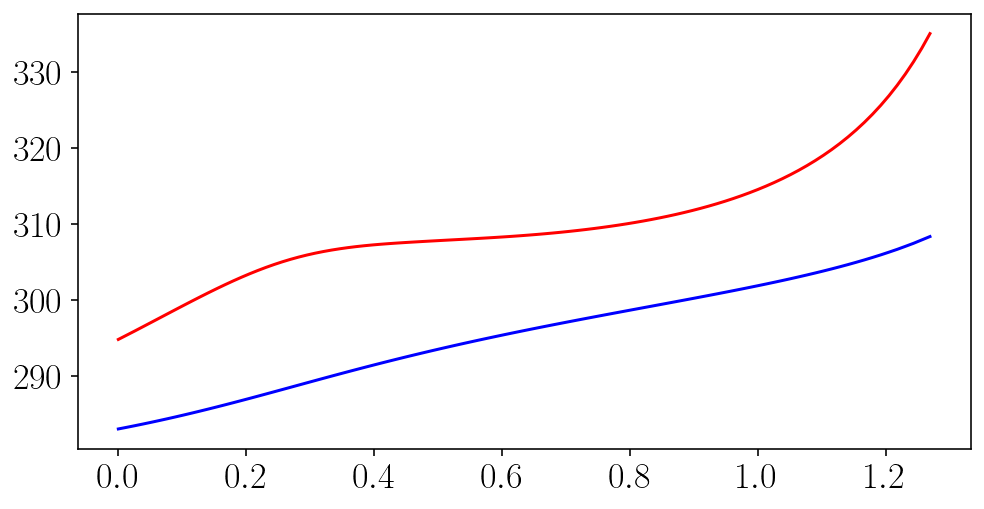

In [122]:
from scipy import optimize

valueU = 2860.0
Per    = 0.4
A      = 1.0

colFluid = {'fluid'     : 'Water', 
             'pressure'  : 1.0e5, 
             'inlet temp': 283,
             'mass flow' : 0.13}

hotFluid = {'fluid'     : 'CO2', 
            'pressure'  : 80.0e5, 
            'inlet temp': 335, 
            'mass flow' : -0.1}


TargetTempCO2Out = 295


def evalDeltaT_Length(length, mfWater, verbose):
    colFluid['mass flow'] = mfWater
    x, Tc, Th = solveHEX(colFluid, hotFluid, length)
    deltaT = (TargetTempCO2Out - Th[0])**2
    if verbose:
        print("Length = %.6f, CO2 out = %.6f, deltaTsq = %.6f" % (length, Th[0], deltaT))
    return deltaT

length = optimize.minimize_scalar(evalDeltaT_Length, 
                                  args=(0.2, True), # these are the additional arguments of evalDeltaT_Length
                                  bounds=(0.01, 20), 
                                  method='bounded').x

print('length = ', length, '\n')

x, Tc, Th = solveHEX(colFluid, hotFluid, length, 100)
plt.figure(figsize=(8,4))
plt.plot(x,Tc,'b-')
plt.plot(x,Th,'r-')

eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
print('exergetic efficiency, eps = ', eps)

## Example: as before, but determine coolant (water) mass flow 

massflowWater = 0.388146, CO2 out = 283.000167, deltaTsq = 143.995982
massflowWater = 0.621854, CO2 out = 282.999924, deltaTsq = 144.001824
massflowWater = 0.243707, CO2 out = 283.001481, deltaTsq = 143.964453
massflowWater = 0.154439, CO2 out = 285.060663, deltaTsq = 98.790418
massflowWater = 0.099268, CO2 out = 302.391990, deltaTsq = 54.641511
massflowWater = 0.065171, CO2 out = 307.473218, deltaTsq = 155.581169
massflowWater = 0.120342, CO2 out = 296.725267, deltaTsq = 2.976546
massflowWater = 0.122658, CO2 out = 295.908278, deltaTsq = 0.824968
massflowWater = 0.128632, CO2 out = 293.811351, deltaTsq = 1.412888
massflowWater = 0.124940, CO2 out = 295.125013, deltaTsq = 0.015628
massflowWater = 0.125244, CO2 out = 295.014264, deltaTsq = 0.000203
massflowWater = 0.125308, CO2 out = 294.990999, deltaTsq = 0.000081
massflowWater = 0.125283, CO2 out = 294.999983, deltaTsq = 0.000000
massflowWater = 0.125280, CO2 out = 295.001203, deltaTsq = 0.000001
massflowWater = 0.125287, CO2 out = 29

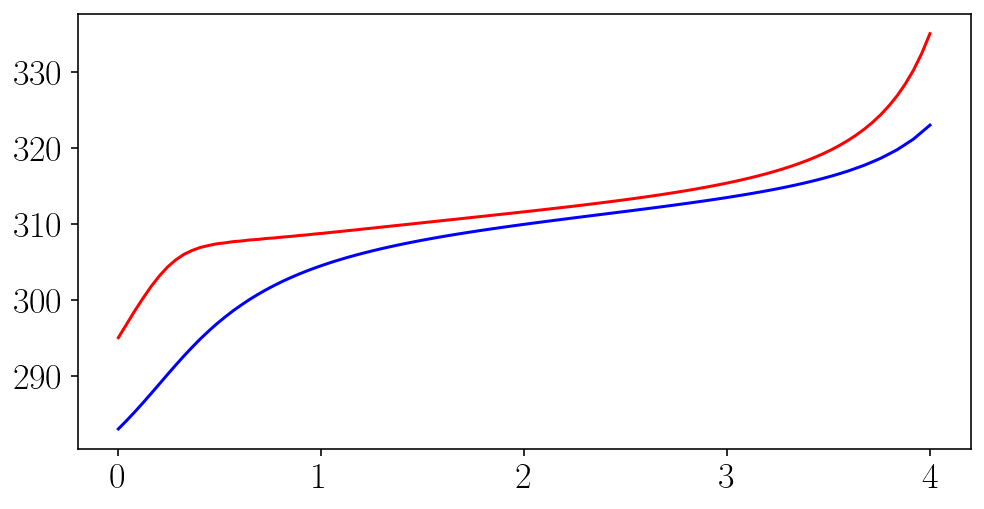

In [121]:
def evalDeltaT_massflow(massflowWater, length, verbose):
    colFluid['mass flow'] = massflowWater
    x, Tc, Th = solveHEX(colFluid, hotFluid, length)
    deltaT = (TargetTempCO2Out - Th[0])**2
    if verbose:
        print("massflowWater = %.6f, CO2 out = %.6f, deltaTsq = %.6f" % (colFluid['mass flow'], Th[0], deltaT))
    return deltaT


TargetTempCO2Out = 295

length = 4
npts = 100
massflowWater = optimize.minimize_scalar(evalDeltaT_massflow, 
                                         args=(length, True),
                                         bounds=(0.01, 1.0), 
                                         method='bounded').x

               
print('massflowWater = ', massflowWater, '\n')

colFluid['mass flow'] = massflowWater
x, Tc, Th = solveHEX(colFluid, hotFluid, length, npts)
plt.figure(figsize=(8,4))
plt.plot(x,Tc,'b-')
plt.plot(x,Th,'r-')

eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
print('exergetic efficiency, eps = ', eps)

## Example: investigate exergetic eff as a function of L 

Allocate an array of lengths from $L_1$ to $L_2$. 

The run an optimization for each $L$ to get the mass flow rate $\dot m_{\textrm{water}}$ which gives the desired CO$_2$ outlet temperature.  

In [128]:
TargetTempCO2Out = 295

length  = np.linspace(1, 10, 10)
eps     = np.zeros(len(length))
mfWater = np.zeros(len(length))

for i,l in enumerate(length):
    mfWater[i] = optimize.minimize_scalar(evalDeltaT_massflow, 
                                          args=(l,False),  # pass length of HEX here!!
                                          bounds=(0.01, 0.35), 
                                          method='bounded').x
    colFluid['mass flow'] = mfWater[i]
    x, Tc, Th = solveHEX(colFluid, hotFluid, l)
    eps[i] = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)

Text(0, 0.5, 'mfWater')

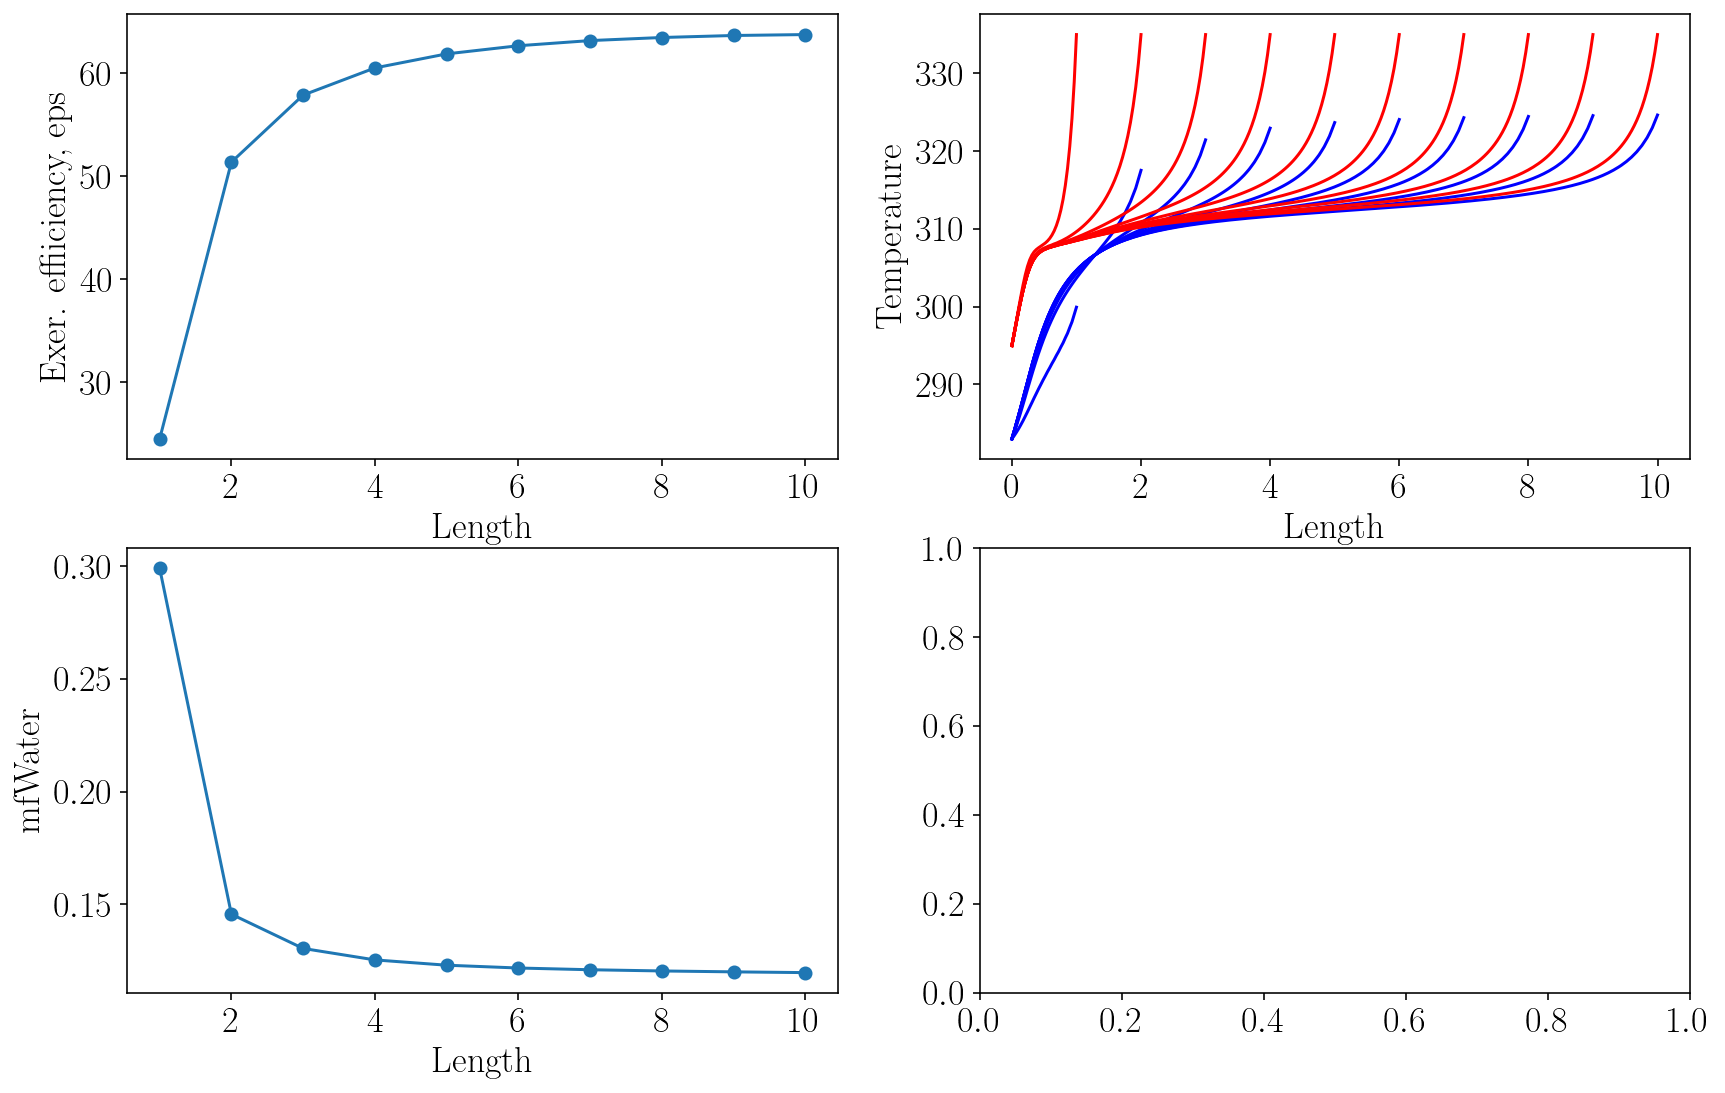

In [129]:
fig, ax = plt.subplots(2,2, figsize=(14,9))
ax[0,0].plot(length, eps, 'o-')
ax[0,0].set_xlabel('Length')
ax[0,0].set_ylabel('Exer. effiiciency, eps')

for i,l in enumerate(length):
    colFluid['mass flow'] = mfWater[i]
    x, Tc, Th = solveHEX(colFluid, hotFluid, length[i])
    ax[0,1].plot(x, Tc, 'b-')
    ax[0,1].plot(x, Th, 'r-')
ax[0,1].set_xlabel('Length')
ax[0,1].set_ylabel('Temperature')

ax[1,0].plot(length, mfWater,'o-')
ax[1,0].set_xlabel('Length')
ax[1,0].set_ylabel('mfWater')


In [130]:
eps

array([24.49906053, 51.35501118, 57.85899108, 60.49401388, 61.85824168,
       62.64773824, 63.14850815, 63.44757528, 63.64257721, 63.73223981])